# MLCL Assignment 1 : Submitted by Chetan Patil
## Vectorization and NLP

## Task 1: CoreNLP Pipeline

![pos](pictures/pos.png)

![ner](pictures/ner.png)

![dependenci](pictures/pos.png)

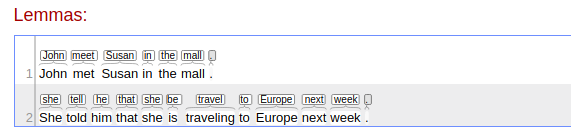

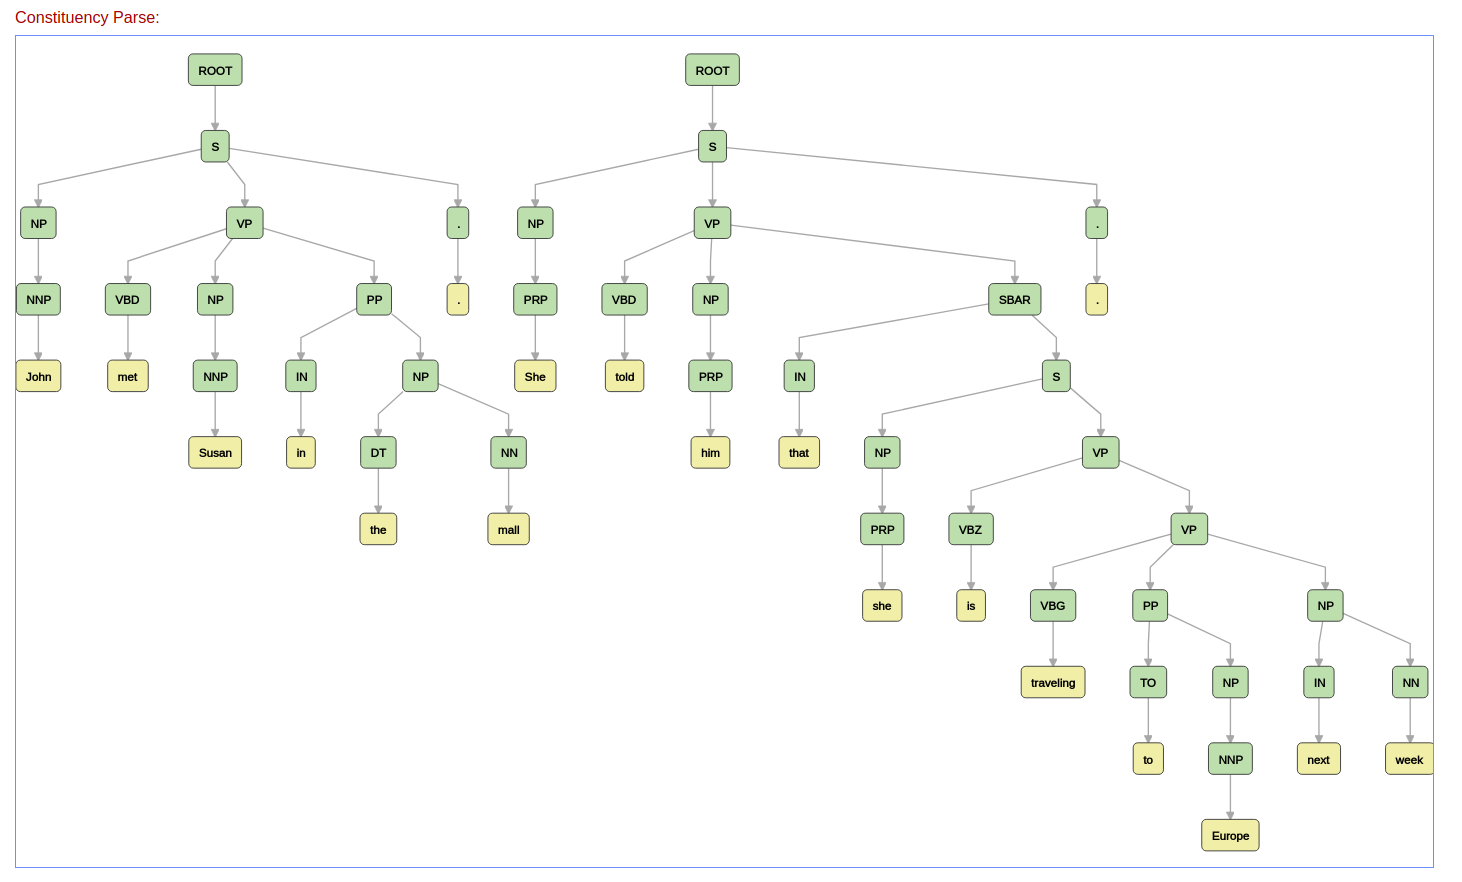

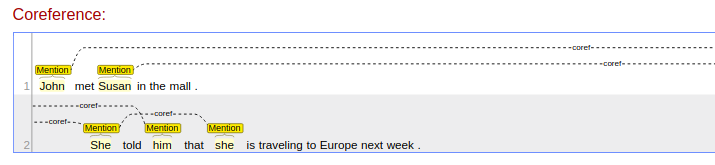

## Vectorization Strategy :
Let us consider a particular task over which the above given features will be useful for us in the study of NLP-analysis

**Task:** Document / Author Classification

**Part-of-speech :**
The part-of-speech property gives us a grammer tag (i.e nouns, verbs, adjectives etc.) associated with every word in the sentence which can be used in our task in order to determine the correct phrases as well as fitting of a particular word in a suitable context.
We can map the number of occurences of a POS tag and include that in a feature vector:

|Noun|Verb|Adverb|Adjective|
|----|----|------|---------|
|5   |2   |0     |1        |

**Named entities :**
Named entities gives us a class/category for which a paricular word belongs to. Similar, to that of POS tags we can take total number of occurences and map them in the feature vector

|Person|Date|Location|Organization|
|----|----|------|---------|
|5   |2   |0     |1        |

**Lemma :**
Lemmatization can be used to detect if two words have same root or not which is another form of text normalization and can be used in our task for stemming purpose.
To include this in feature vector we simply take the ratio of total # of tokens / # of unique lemmas

|Lemma|
|-----|
|1.18|

**Coreference :**
In our task coreference can be used to link the relationship between names and corresponding tags referred for them in future sentences. We take the count of genders i.e Male, Female, Neutral references from coreference and map them to vector

|Male|Female|Neutral|
|----|----|------|
|1   |1   |0     |

**Dependency Parse Tree :**
Using dependecy tree we can quantify the usage of passive or active voice by extracting the total number of occurences of auxpass and subjpass and map them in the feature vector

|auxpass|nsubjpass|
|----|----|
|1   |1   |

**Constituent Parse Tree:**
Contituent parse tree can be used to extract the chunks of data that relate to grammers and related phrases from the tree. We do this by taking the count of leaf nodes for respectie phrases

|NP|VP|
|----|----|
|5   |7   |


### Full Feature vector:
The full feature vector will consist of all the above given vectors combined in one with the following mapping sequence of properties:
[POS tags, Named Entities, Lemma, Coreferences, Dependecy parse tree, constituent parse tree]
where each element in above sequence represents the continous flatten numpy vector which in turn can be used to train our model.

## Task 2:  Spacy NLP Pipeline

In [11]:
# Required modules
import spacy
from spacy import displacy

In [12]:
nlp = spacy.load('en')
sentence = nlp(u'John met Susan in the mall. She told him that she is traveling to Europe next week.')

#### Tokens:

In [13]:
for token in sentence:
    print(token)

John
met
Susan
in
the
mall
.
She
told
him
that
she
is
traveling
to
Europe
next
week
.


#### Part-of-Speech:

In [14]:
for token in sentence:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)

John john PROPN NNP nsubj
met meet VERB VBD ROOT
Susan susan PROPN NNP dobj
in in ADP IN prep
the the DET DT det
mall mall NOUN NN pobj
. . PUNCT . punct
She -PRON- PRON PRP nsubj
told tell VERB VBD ROOT
him -PRON- PRON PRP dobj
that that ADP IN mark
she -PRON- PRON PRP nsubj
is be VERB VBZ aux
traveling travel VERB VBG ccomp
to to ADP IN prep
Europe europe PROPN NNP pobj
next next ADJ JJ amod
week week NOUN NN npadvmod
. . PUNCT . punct


### Named Entities: 
We can extract named entities from documents using the ent

In [15]:
displacy.render(sentence, style = 'ent', jupyter = True)

In [16]:
for ent in sentence.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

John 0 4 PERSON
Susan 9 14 PERSON
Europe 66 72 LOC
next week 73 82 DATE


### Dependency Parse:

In [17]:
displacy.render(sentence, style = "dep", jupyter = True)
for token in sentence:
    print(token.text, token.dep_, token.head.text, token.head.pos_, [child for child in token.children])

John nsubj met VERB []
met ROOT met VERB [John, Susan, in, .]
Susan dobj met VERB []
in prep met VERB [mall]
the det mall NOUN []
mall pobj in ADP [the]
. punct met VERB []
She nsubj told VERB []
told ROOT told VERB [She, him, traveling, .]
him dobj told VERB []
that mark traveling VERB []
she nsubj traveling VERB []
is aux traveling VERB []
traveling ccomp told VERB [that, she, is, to, week]
to prep traveling VERB [Europe]
Europe pobj to ADP []
next amod week NOUN []
week npadvmod traveling VERB [next]
. punct told VERB []


### Lemmas:

In [18]:
for token in sentence:
    print(token.text, token.lemma_)

John john
met meet
Susan susan
in in
the the
mall mall
. .
She -PRON-
told tell
him -PRON-
that that
she -PRON-
is be
traveling travel
to to
Europe europe
next next
week week
. .


## Vectorization Strategy :
 
**Note :** The vectorization strategy for both CoreNLP and Spacy will be same just the Final Feature vector will not contain the subvectors related to constituent parse tree and coreferences as functionality for them is not supported by spacy

### Comparision:
Using Spacy can help us to find the integrated word vectors which will help us in the task to define the similarity between the document text. While this feature is absent in CoreNLP pipeline

The difference in the outputs can be determined in above given sentence at the word "next" while checking POS tags spacy tags the word as ADJ while CoreNLP portrays that as IN. This might depend upon the different corpora used by them.


## Task 3 :

#### Note: Considered the counts for limited labels for POS, NER, Dependencies based on above sentence as per question. We can add the count for all of tags which are not present and assign them to 0 which will be sparse vector. 

### Part 1: Taking JSON from server and mapping to Python data structure (CoreNLP)
This part uses the pywrap as the wrapper to map required data structures to dictionary of lists associated with respective properties except dependencies and constituent parse trees which are mapped to lists using JSON in the form of dictionary traversing.
In order to parse constituent tree and get NP and VP values the tree is traversed by passing it to nltk tree.

In [1]:
from corenlp_pywrap import pywrap
from nltk.tree import Tree
import pprint

In [2]:
#mapper
corefs = []
gender_count = {} #specific
tokens = []
pos = []
pos_count = {'N':0,'V':0,'J':0,'R':0}  #specific
lemma = []
ner = []
ner_count = {'PERSON': 0, 'DATE': 0, 'LOCATION': 0, 'ORGANIZATION': 0}  #specific
dependencies = []
dependency_count = {'aux' : 0, 'auxpass': 0, 'nsubjpass' : 0, 'nsubj':0, 'dobj':0} #nsubj dobj added just for check
noun_phrase_count = 0
verb_phrase_count = 0

text = ('John met Susan in the mall. She told him that she is traveling to Europe next week.')
full_annotator_list = ["tokenize", "pos", "lemma", "ner", "parse", "depparse", "dcoref"]
cn = pywrap.CoreNLP(url='http://localhost:9000', annotator_list=full_annotator_list)

#Calling basic function which would return a 'requests' object
out = cn.basic(text, out_format='json')
token_dict = cn.arrange(text)
outputjson = out.json()
obj = outputjson['corefs']

def updateGenderCount(gender):
    if gender in gender_count:
        gender_count[gender] += 1
    else:
        gender_count[gender] = 1

def updatePOSCount(pos):
    if pos[0] in pos_count:
        pos_count[pos[0]] += 1

def updateNERCount(entity):
    if entity in ner_count:
        ner_count[entity] += 1

#Extracting Coreferences
for values in obj:
    for values1 in obj[values]:
        tup = (values1['text'], values1['gender'], values1['number'], values1['type'])
        updateGenderCount(values1['gender'])
        corefs.append(tup)
#Extracting Parts-of-Speech
for pos in token_dict['pos']:
    if(pos[0] in ('N','V','J','R')):
        updatePOSCount(pos)

#Extracting Named Entities
for entity in token_dict['ner']:
    if(entity not in ('O')):
        updateNERCount(entity)

#Extracting Dependencies
obj = outputjson['sentences']
for values in obj:
    basicDependencies = values['basicDependencies']
    for data in basicDependencies:
        tup = (data['dependentGloss'], data['dep'], data['governorGloss'])
        dependencies.append(tup)
        if data['dep'] in dependency_count.keys():
            dependency_count[data['dep']] += 1

#Ref: https://www.winwaed.com/blog/2012/01/20/extracting-noun-phrases-from-parsed-trees/
def ExtractPhrases( myTree, phrase):
    myPhrases = []
    if (myTree.label() == phrase):
        myPhrases.append( myTree.copy(True) )
    for child in myTree:
        if (type(child) is Tree):
            list_of_phrases = ExtractPhrases(child, phrase)
            if (len(list_of_phrases) > 0):
                myPhrases.extend(list_of_phrases)
    return myPhrases
print("Tokens\n", token_dict["word"],"\n")
print("Parts-of-Speech", token_dict["pos"],"\n")
print("Named Entities\n", token_dict["ner"],"\n")
print("Lemma\n", token_dict["lemma"],"\n")
print("Coreferences \n",corefs,"\n")
print("Dependencies\n",dependencies,"\n")
print("Constituent Parse Trees\n")
for tree in outputjson['sentences']:
    parsetree = Tree.fromstring(tree['parse'])
    list_of_noun_phrases = ExtractPhrases(parsetree, 'NP')
    list_of_verb_phrases = ExtractPhrases(parsetree, 'VP')
    for phrase in list_of_noun_phrases:
        noun_phrase_count += 1
    for phrase in list_of_verb_phrases:
        verb_phrase_count += 1
    parsetree.pretty_print()
    


Tokens
 ['John', 'met', 'Susan', 'in', 'the', 'mall', '.', 'She', 'told', 'him', 'that', 'she', 'is', 'traveling', 'to', 'Europe', 'next', 'week', '.'] 

Parts-of-Speech ['NNP', 'VBD', 'NNP', 'IN', 'DT', 'NN', '.', 'PRP', 'VBD', 'PRP', 'IN', 'PRP', 'VBZ', 'VBG', 'TO', 'NNP', 'IN', 'NN', '.'] 

Named Entities
 ['PERSON', 'O', 'PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'LOCATION', 'DATE', 'DATE', 'O'] 

Lemma
 ['John', 'meet', 'Susan', 'in', 'the', 'mall', '.', 'she', 'tell', 'he', 'that', 'she', 'be', 'travel', 'to', 'Europe', 'next', 'week', '.'] 

Coreferences 
 [('Europe', 'NEUTRAL', 'SINGULAR', 'PROPER'), ('the mall', 'NEUTRAL', 'SINGULAR', 'NOMINAL'), ('Susan', 'FEMALE', 'SINGULAR', 'PROPER'), ('She', 'FEMALE', 'SINGULAR', 'PRONOMINAL'), ('she', 'FEMALE', 'SINGULAR', 'PRONOMINAL'), ('John', 'MALE', 'SINGULAR', 'PROPER'), ('him', 'MALE', 'SINGULAR', 'PRONOMINAL'), ('next week', 'UNKNOWN', 'SINGULAR', 'PROPER')] 

Dependencies
 [('met', 'ROOT', 'ROOT'), ('J

## Vectorization of CoreNLP JSON

In [3]:
import numpy as np

pos_vector = np.array([pos_count[key] for key in sorted(pos_count)])
ner_vector = np.array([ner_count[key] for key in sorted(ner_count)])
lemma = np.array([len(token_dict['word'])/float(len(set(token_dict['lemma'])))])
coref_gender_vector = np.array([gender_count[key] for key in sorted(gender_count)])
dependency_parse_vector = np.array([dependency_count[key] for key in sorted(dependency_count)])
noun_phrase_count = np.array([noun_phrase_count])
verb_phrase_count = np.array([verb_phrase_count])

#sequence
feature_vector = [pos_vector, ner_vector, lemma, coref_gender_vector, dependency_parse_vector, noun_phrase_count, verb_phrase_count]
f_vector = [val for i in feature_vector for val in i]
print("Full vector:\n",np.array(f_vector))

Full vector:
 [0.         5.         0.         4.         2.         1.
 0.         2.         1.11764706 3.         2.         2.
 1.         1.         0.         2.         3.         0.
 8.         4.        ]


### Part 2: Spacy NLP-objects to vectors
We can similarly make vectors of spacy objects as of that of CoreNLP

In [6]:
import spacy
nlp = spacy.load('en')
sentence = nlp(u'John met Susan in the mall. She told him that she is traveling to Europe next week.')
# mappers
sp_tokens = []
sp_lemma = []
sp_dependencies = []
sp_dependency_count = {'aux': 0 , 'auxpass': 0, 'nsubjpass' : 0, 'nsubj':0, 'dobj':0}
sp_ner = []
sp_ner_count = {'PERSON': 0, 'DATE': 0, 'LOCATION': 0, 'ORGANIZATION': 0}  #specific
sp_pos = []
sp_pos_count = {'N':0,'V':0,'J':0,'R':0}

#counters for vectors
def spUpdatePOSCount(pos):
    if pos[0] in sp_pos_count:
        sp_pos_count[pos[0]] += 1    

def spUpdateNERCount(entity):
    if entity in sp_ner_count:
        sp_ner_count[entity] += 1
        
def spUpdateDependencyCount(dependency):
    if dependency in sp_dependency_count:
        sp_dependency_count[dependency] += 1

#Extracting tokens, lemmas, dependencies, parts-of-speech
for token in sentence:
    #lemma
    sp_tokens.append(token)
    sp_lemma.append(token.lemma_)
    #dependencies
    tup_dependencies = (token.text, token.dep_, token.head.text)
    sp_dependencies.append(tup_dependencies)
    if(token.dep_ in sp_dependency_count.keys()):
        spUpdateDependencyCount(token.dep_)
    #parts-of-speech
    tup_pos = (token.text, token.pos_, token.tag_)
    sp_pos.append(tup_pos)
    if(token.tag_[0] in sp_pos_count.keys()):
        spUpdatePOSCount(token.tag_)
    
#Extracting named entities
for ent in sentence.ents:
    tup_ent = (ent.text, ent.label_)
    sp_ner.append(tup_ent)
    if ent.label_ in sp_ner_count.keys():
        spUpdateNERCount(ent.label_)

print("Tokens\n", sp_tokens,"\n")
print("Parts-of-Speech\n", sp_pos,"\n")
print("Named Entities\n", sp_ner,"\n")
print("Lemma\n", sp_lemma,"\n")
print("Dependencies\n",sp_dependencies,"\n")


Tokens
 [John, met, Susan, in, the, mall, ., She, told, him, that, she, is, traveling, to, Europe, next, week, .] 

Parts-of-Speech
 [('John', 'PROPN', 'NNP'), ('met', 'VERB', 'VBD'), ('Susan', 'PROPN', 'NNP'), ('in', 'ADP', 'IN'), ('the', 'DET', 'DT'), ('mall', 'NOUN', 'NN'), ('.', 'PUNCT', '.'), ('She', 'PRON', 'PRP'), ('told', 'VERB', 'VBD'), ('him', 'PRON', 'PRP'), ('that', 'ADP', 'IN'), ('she', 'PRON', 'PRP'), ('is', 'VERB', 'VBZ'), ('traveling', 'VERB', 'VBG'), ('to', 'ADP', 'IN'), ('Europe', 'PROPN', 'NNP'), ('next', 'ADJ', 'JJ'), ('week', 'NOUN', 'NN'), ('.', 'PUNCT', '.')] 

Named Entities
 [('John', 'PERSON'), ('Susan', 'PERSON'), ('Europe', 'LOC'), ('next week', 'DATE')] 

Lemma
 ['john', 'meet', 'susan', 'in', 'the', 'mall', '.', '-PRON-', 'tell', '-PRON-', 'that', '-PRON-', 'be', 'travel', 'to', 'europe', 'next', 'week', '.'] 

Dependencies
 [('John', 'nsubj', 'met'), ('met', 'ROOT', 'met'), ('Susan', 'dobj', 'met'), ('in', 'prep', 'met'), ('the', 'det', 'mall'), ('mall', 

# Vectorization of Spacy NLP-Objects

In [7]:
sp_pos_vector = np.array([sp_pos_count[key] for key in sorted(sp_pos_count)])
sp_ner_vector = np.array([sp_ner_count[key] for key in sorted(sp_ner_count)])
sp_lemma_vector = np.array([len(sp_tokens)/float(len(set(sp_lemma)))])
sp_dependency_vector = np.array([sp_dependency_count[key] for key in sorted(sp_dependency_count)])

sp_feature_vector = [sp_pos_vector, sp_ner_vector, sp_lemma_vector, sp_dependency_vector]
sp_f_vector = [val for i in sp_feature_vector for val in i]
sp_f_vector = np.array(sp_f_vector)
print("Full vector:\n",sp_f_vector)

Full vector:
 [1.     5.     0.     4.     1.     0.     0.     2.     1.1875 1.
 0.     2.     3.     0.    ]


## Task 4:
Text Classification based on Spacy and fasttext vectors and embeddings

Used fasttext and spacy python libraries for text classification for 2 classes i.e Films and Politics which I created using the Wikipedia from the websites (https://en.wikipedia.org/wiki/Politics) for Politics and (https://en.wikipedia.org/wiki/Film) for Films. The data contains total of 100 sentences 50 for fils and 50 for politics class. I used supervised learning model to train the data which uses 'model_filmpolitics.bin'. The 
model was tested on 5 sentences and respective labels were predicted.

The 'model_filmpolitics.vec' is takend as input vector in spacy in order to get similarity between tokens based on our corpus 

In [1]:
import fasttext
import spacy
from __future__ import unicode_literals
import plac
import numpy
from spacy.language import Language

In [7]:
model = fasttext.supervised('filmpolitics.txt', 'model_filmpolitics')

classifier = fasttext.load_model('model_filmpolitics.bin')

#prediction text
text = ['House Minority Leader Nancy Pelosi (D-Calif.) has earned the ire of Republicans for suggesting that major corporations are giving workers “crumbs” while top executives reap bonuses after passage of the GOP’s tax revision plan.',
'The 10 Most Anticipated Movie Trailers Of 2018',
'Going into "Avengers: Infinity War," only one of the six Infinity Stones remains unaccounted for - the Soul Stone.',
'The White House Denies National Security Adviser H.R. McMaster Is Departing',
'President Trump told business executives gathered at the White House Thursday that he would impose tariffs on steel and aluminum next week.']


labels = classifier.predict(text)
print(labels)

[['__label__politics'], ['__label__film'], ['__label__politics'], ['__label__film'], ['__label__politics']]


In [10]:
#Ref: https://spacy.io/usage/examples
# load pre-trained vectors and 
def vec(vectors_loc, lang=None):
    if lang is None:
        nlp = Language()
    else:
        nlp = spacy.blank(lang)
    with open(vectors_loc, 'rb') as file_:
        header = file_.readline()
        nr_row, nr_dim = header.split()
        nlp.vocab.reset_vectors(width=int(nr_dim))
        for line in file_:
            line = line.rstrip().decode('utf8')
            pieces = line.rsplit(' ', int(nr_dim))
            word = pieces[0]
            vector = numpy.asarray([float(v) for v in pieces[1:]], dtype='f')
            nlp.vocab.set_vector(word, vector)  # add the vectors to the vocab
    # test the vectors and similarity
    tokens = nlp(text[3])
    for token1 in tokens:
        for token2 in tokens:
            print(token1 , token2, token1.similarity(token2))
vec("./model_filmpolitics.vec")

The The 1.0
The White 0.0
The House 0.0
The Denies 0.0
The National 0.0
The Security 0.0
The Adviser 0.0
The H.R. 0.0
The McMaster 0.0
The Is 0.0
The Departing 0.0
White The 0.0
White White 1.0
White House 0.0
White Denies 0.0
White National 0.0
White Security 0.0
White Adviser 0.0
White H.R. 0.0
White McMaster 0.0
White Is 0.0
White Departing 0.0
House The 0.0
House White 0.0
House House 1.0
House Denies 0.0
House National 0.0
House Security 0.0
House Adviser 0.0
House H.R. 0.0
House McMaster 0.0
House Is 0.0
House Departing 0.0
Denies The 0.0
Denies White 0.0
Denies House 0.0
Denies Denies 1.0
Denies National 0.0
Denies Security 0.0
Denies Adviser 0.0
Denies H.R. 0.0
Denies McMaster 0.0
Denies Is 0.0
Denies Departing 0.0
National The 0.0
National White 0.0
National House 0.0
National Denies 0.0
National National 1.0
National Security 0.0
National Adviser 0.0
National H.R. 0.0
National McMaster 0.0
National Is 0.0
National Departing 0.0
Security The 0.0
Security White 0.0
Security Hou

**References:**

Code taken from respective sites has been mention above codes, some provided by Prof. Damir Cavar

https://stanfordnlp.github.io/CoreNLP/

https://pypi.python.org/pypi/fasttext

https://spacy.io/usage/

Discussion with Dheeraj Singh